In [41]:
from pathlib import Path
import os
import pandas as pd
import numpy as np
import cv2
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import ConfusionMatrixDisplay
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
import random
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam, Adamax
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Activation, Dropout, BatchNormalization
from tensorflow.keras import regularizers
from keras.callbacks import EarlyStopping, LearningRateScheduler
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.resnet50 import preprocess_input
import seaborn as sns
import ipywidgets as widgets

# **Preparation of the data**

In [42]:
def get_data_paths(data_dir):
    
    file_paths = []
    label_names = []

    directory = os.listdir(data_dir)
    
    for subdirect in directory:
        if subdirect == 'Master Folder':
            continue
            
        dirpath = os.path.join(data_dir, subdirect)
        filelist = os.listdir(dirpath)
        for file in filelist:
            fpath = os.path.join(dirpath, file)
            file_paths.append(fpath)
            label_names.append(subdirect)
            
    return file_paths, label_names


def create_df(file_paths, label_names):
    df = pd.concat([pd.Series(file_paths, name= 'Paths'), pd.Series(label_names, name='Labels')], axis= 1)
    return df

In [3]:
data_dir = '/kaggle/input/pets-facial-expression-dataset'
file_paths, label_names = get_data_paths(data_dir)
df = create_df(file_paths, label_names)
df

,Paths,Labels
0,/kaggle/input/pets-facial-expression-dataset/O...,Other
1,/kaggle/input/pets-facial-expression-dataset/O...,Other
2,/kaggle/input/pets-facial-expression-dataset/O...,Other
3,/kaggle/input/pets-facial-expression-dataset/O...,Other
4,/kaggle/input/pets-facial-expression-dataset/O...,Other
...,...,...
995,/kaggle/input/pets-facial-expression-dataset/h...,happy
996,/kaggle/input/pets-facial-expression-dataset/h...,happy
997,/kaggle/input/pets-facial-expression-dataset/h...,happy
998,/kaggle/input/pets-facial-expression-dataset/h...,happy


In [43]:
print('Labels number:', df['Labels'].nunique())
class_names = df['Labels'].unique()
print(class_names)

Labels number: 4
['Other' 'Angry' 'Sad' 'happy']


In [44]:
count_images_per_category = df.groupby(['Labels']).count()
count_images_per_category

,Paths
Labels,
Angry,250
Other,250
Sad,250
happy,250


(179, 179, 3)
(224, 224, 3)
(179, 179, 3)
(224, 224, 3)
(179, 179, 3)
(224, 224, 3)
(224, 224, 3)
(179, 179, 3)
(224, 224, 3)
(224, 224, 3)
(179, 179, 3)
(179, 179, 3)
(224, 224, 3)
(224, 224, 3)
(224, 224, 3)
(224, 224, 3)
(224, 224, 3)
(224, 224, 3)
(224, 224, 3)
(224, 224, 3)
(224, 224, 3)
(179, 179, 3)
(179, 179, 3)
(224, 224, 3)
(179, 179, 3)
(224, 224, 3)
(179, 179, 3)
(179, 179, 3)
(224, 224, 3)
(179, 179, 3)
(179, 179, 3)
(224, 224, 3)
(179, 179, 3)
(224, 224, 3)
(179, 179, 3)
(179, 179, 3)
(179, 179, 3)
(179, 179, 3)
(224, 224, 3)
(179, 179, 3)


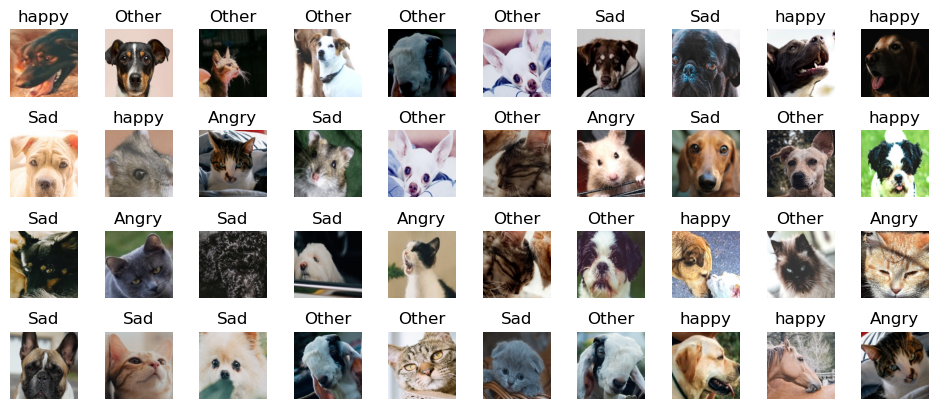

In [45]:
n_rows = 4
n_cols = 10
plt.figure(figsize=(n_cols * 1.2, n_rows * 1.2))

for row in range(n_rows):
    for col in range(n_cols):
        index = n_cols * row + col
        index_img = random.randint(1,1000)
        plt.subplot(n_rows, n_cols, index + 1)
        img_path = df['Paths'][index_img]
        img = plt. imread(img_path)
        print(img.shape)
        plt.imshow(img)
        plt.axis('off')
        plt.title(df['Labels'][index_img], fontsize=12)
plt.subplots_adjust(wspace=0.2, hspace=0.5)

plt.show()

# **Preparation of train and test dataset**

In [46]:
# train dataframe
train_df, test_df = train_test_split(df, train_size= 0.8, shuffle= True, random_state= 42)

In [48]:
batch_size = 16
img_shape = (224, 224, 3)

train = ImageDataGenerator(rotation_range=30,
                           width_shift_range=0.2,
                           height_shift_range=0.2,
                           brightness_range=[0.2,0.4],
                           zoom_range=0.2,
                           horizontal_flip=True,
                           vertical_flip=True)

test = ImageDataGenerator(rotation_range=30,
                           width_shift_range=0.2,
                           height_shift_range=0.2,
                           brightness_range=[0.2,0.4],
                           zoom_range=0.2,
                           horizontal_flip=True,
                           vertical_flip=True)

train_gen = train.flow_from_dataframe(train_df, 
                                       x_col= 'Paths', 
                                       y_col= 'Labels', 
                                       target_size= img_shape[:2], 
                                       class_mode= 'categorical',
                                       color_mode= 'rgb', 
                                       shuffle= True, 
                                       batch_size= batch_size)

test_gen = test.flow_from_dataframe(test_df, 
                                      x_col= 'Paths', 
                                      y_col= 'Labels', 
                                      target_size= img_shape[:2], 
                                      class_mode= 'categorical',
                                      color_mode= 'rgb', 
                                      shuffle= False, 
                                      batch_size= batch_size)

Found 800 validated image filenames belonging to 4 classes.
Found 200 validated image filenames belonging to 4 classes.


# **Model training**


In [54]:
initial_learning_rate = 0.01
epochs = 100

base_model = tf.keras.applications.resnet50.ResNet50(include_top= False, weights= "imagenet", input_shape= img_shape, pooling= 'max')
base_model.trainable = False

model = Sequential([
    base_model,
    BatchNormalization(),
    Dense(256, activation='relu'),
    Dense(128, activation= 'relu'),
    Dropout(rate= 0.3),
    Dense(len(class_names), activation= 'softmax')
])

model.compile(Adamax(learning_rate= initial_learning_rate), loss= 'categorical_crossentropy', metrics= ['accuracy'])

model.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 2048)              23587712  
                                                                 
 batch_normalization_7 (Batc  (None, 2048)             8192      
 hNormalization)                                                 
                                                                 
 dense_21 (Dense)            (None, 256)               524544    
                                                                 
 dense_22 (Dense)            (None, 128)               32896     
                                                                 
 dropout_7 (Dropout)         (None, 128)               0         
                                                                 
 dense_23 (Dense)            (None, 4)                 516       
                                                      

In [55]:
early_stopping = EarlyStopping(monitor='val_accuracy', 
                               patience=10, 
                               restore_best_weights=True,
                               mode='max',
                              )

def cosine_decay(step):
    step = min(step, epochs)
    cosine_decay = 0.5 * (1 + np.cos(np.pi * step / epochs))
    return initial_learning_rate * cosine_decay

lr_scheduler = LearningRateScheduler(cosine_decay)

In [56]:
epochs = 100

history = model.fit(x=train_gen,
                    epochs= epochs,
                    verbose= 1,
                    validation_data= test_gen, 
                    validation_steps= None,
                    shuffle= False,
                    callbacks=[early_stopping, lr_scheduler])

Epoch 1/100
50/50 [==============================] - 24s 361ms/step - loss: 2.7231 - accuracy: 0.3550 - val_loss: 2.9193 - val_accuracy: 0.3100 - lr: 0.0100
Epoch 2/100
50/50 [==============================] - 17s 336ms/step - loss: 1.2187 - accuracy: 0.4538 - val_loss: 1.4534 - val_accuracy: 0.4400 - lr: 0.0100
Epoch 3/100
50/50 [==============================] - 16s 319ms/step - loss: 1.0442 - accuracy: 0.5500 - val_loss: 1.2119 - val_accuracy: 0.5850 - lr: 0.0100
Epoch 4/100
50/50 [==============================] - 17s 334ms/step - loss: 0.9426 - accuracy: 0.5962 - val_loss: 0.9724 - val_accuracy: 0.6100 - lr: 0.0100
Epoch 5/100
50/50 [==============================] - 16s 320ms/step - loss: 0.8537 - accuracy: 0.6700 - val_loss: 0.8812 - val_accuracy: 0.6500 - lr: 0.0100
Epoch 6/100
50/50 [==============================] - 16s 323ms/step - loss: 0.8003 - accuracy: 0.7075 - val_loss: 0.7913 - val_accuracy: 0.7000 - lr: 0.0099
Epoch 7/100
50/50 [==============================] - 17s 3

# **Model evaluation**

In [58]:
test_score = model.evaluate(test_gen, verbose= 1)

print("Test Loss: ", test_score[0])
print("Test Accuracy: ", test_score[1])

13/13 [==============================] - 3s 242ms/step - loss: 0.1348 - accuracy: 0.9600
Test Loss:  0.13480575382709503
Test Accuracy:  0.9599999785423279


In [59]:
pred = model.predict(test_gen)
y_pred = np.argmax(pred, axis=1)

13/13 [==============================] - 4s 240ms/step


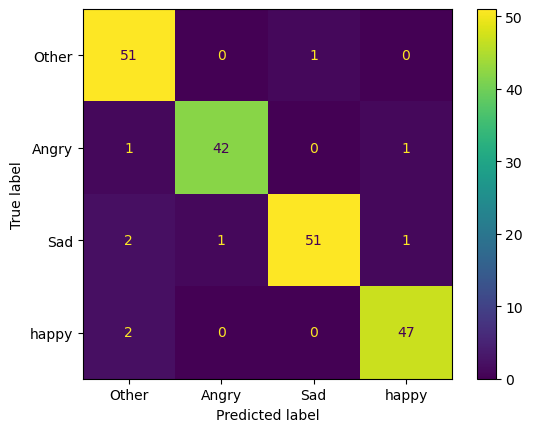

In [60]:
cnf_matrix = confusion_matrix(test_gen.classes, y_pred)
disp = ConfusionMatrixDisplay(cnf_matrix, display_labels=class_names)
disp.plot()

In [61]:
print(classification_report(test_gen.classes, y_pred, target_names= class_names))

              precision    recall  f1-score   support

       Other       0.91      0.98      0.94        52
       Angry       0.98      0.95      0.97        44
         Sad       0.98      0.93      0.95        55
       happy       0.96      0.96      0.96        49

    accuracy                           0.95       200
   macro avg       0.96      0.96      0.96       200
weighted avg       0.96      0.95      0.96       200



In [64]:
def plot_learning_curves(history, model_name):
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    
    index_loss = np.argmin(history.history['val_loss'])
    val_lowest = history.history['val_loss'][index_loss]
    loss_label = f'best epoch= {str(index_loss + 1)}'
    plt.scatter(index_loss + 1, val_lowest, s= 150, c= 'blue', label= loss_label)
    
    plt.title(f'{model_name} loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()


def plot_accuracy_curves(history, model_name):
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    
    index_acc = np.argmax(history.history['val_accuracy'])
    acc_highest = history.history['val_accuracy'][index_acc]
    acc_label = f'best epoch= {str(index_acc + 1)}'
    plt.scatter(index_acc + 1 , acc_highest, s= 150, c= 'blue', label= acc_label)
    
    plt.title(f'{model_name} accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()

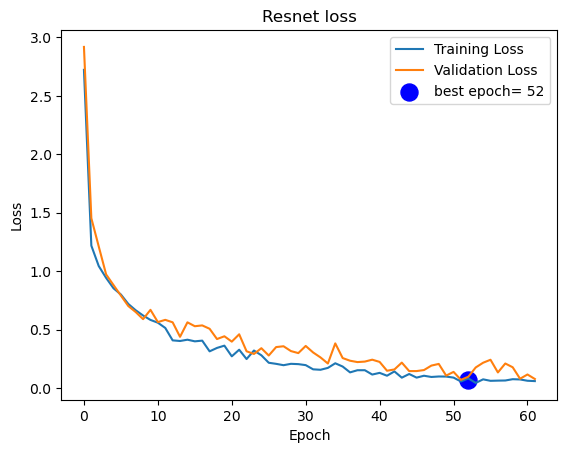

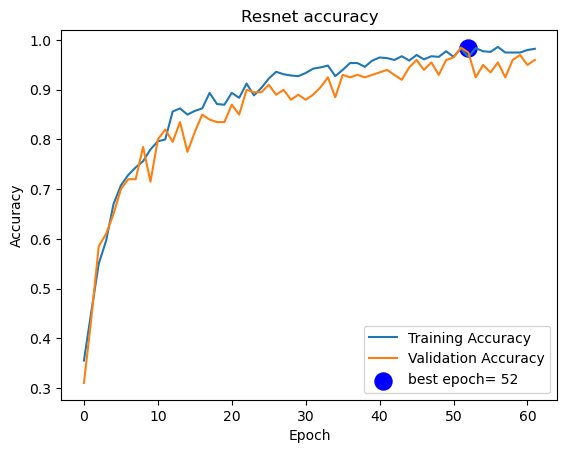

In [65]:
plot_learning_curves(history, 'Resnet')
plot_accuracy_curves(history, 'Resnet')

# **Use of the model**

In [18]:
# model.save_weights('my_model_weights.h5')

In [66]:
test_df = test_df.reset_index()
test_df

,index,Paths,Labels
0,521,/kaggle/input/pets-facial-expression-dataset/S...,Sad
1,737,/kaggle/input/pets-facial-expression-dataset/S...,Sad
2,740,/kaggle/input/pets-facial-expression-dataset/S...,Sad
3,660,/kaggle/input/pets-facial-expression-dataset/S...,Sad
4,411,/kaggle/input/pets-facial-expression-dataset/A...,Angry
...,...,...,...
195,408,/kaggle/input/pets-facial-expression-dataset/A...,Angry
196,332,/kaggle/input/pets-facial-expression-dataset/A...,Angry
197,208,/kaggle/input/pets-facial-expression-dataset/O...,Other
198,613,/kaggle/input/pets-facial-expression-dataset/S...,Sad


In [68]:
%matplotlib inline

def show_img(image_nr):
    print('Image nr', image_nr)
    img_path = test_df['Paths'][image_nr]
    real_label = test_df['Labels'][image_nr]
    labels = {0: "Other", 1:"Angry", 2: "Sad", 3: "Happy"}
    print('\nReal label:', real_label)
    
    img = image.load_img(img_path, target_size=(224, 224))
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array = preprocess_input(img_array)
    y_pred = model.predict(img_array)
    p = y_pred.max()
    pozycja = np.argmax(y_pred, axis=None)
    print('Predict label: {}\nProbability: {:.2%}, '.format(labels[pozycja], p))
    plt.imshow(img)
    plt.axis('off')
    plt.show()
    
widgets.interact(show_img, image_nr=widgets.IntSlider(continuous_update=True, min=0, 
                                                      max=199, step=1,
                                                      description='Choose image number:',
                                                      orientation='horizontal'))

interactive(children=(IntSlider(value=0, description='Choose image number:', max=199), Output()), _dom_classes…

<function __main__.show_img(image_nr)>